In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

import wordle as wd


%load_ext autoreload
%autoreload 2

DATA_PATH = Path("../data/")
ALLOWED_WORDS_FNAME = "raw/allowed_words.txt"
POSSIBLE_WORDS_FNAME = "raw/possible_words.txt"
WORDS_PAIRS_FNAME = "transformed/guess_solution_map_{version}.pkl"
IMG_PATH = Path("../images/")

WORD = "crepe"

# Wordle Solver
## Goal
* build an agent that can play Wordle, with the goal to maximize its score on a given evaluation set.

## Heuristic
* use $entropy=\sum p * log_2(p)$ to calculate by how much a given guess is expected to reduce the number of possible choices (wegihted average)
* v1: no prior on what are actual possible solutions
* v2: using knowledge about actual possible words
* v3: add 2 step lookup (consider expected entropy given best next guess following original one and guess outcome)

## Setup Game Engine
* game rules encapsulated in `WordleGame` class
* color-coded HTML display of guess outcome: `display_wordle_guess_outcome`
* basic function to validate whether a guess is possible: `is_word_possible_given_guess_outcome`

## TO DO
- [x] create full player with greedy approach on entropy-minimizing strategy
- [x] create evaluation suite
    - play games with all possible_words
    - record number of guesses
    - generate averages
- [x] evaluation result visualization
- [x] refactor word distrib visualization
- [x] add improvement with non uniform entropies
- [ ] add 2 steps look-ahead player
- [ ] refactor `map.py`
- [ ] write summary in README file


In [2]:
game = wd.WordleGame("crate")
outcome = game.evaluate_guess("treta")
wd.display_wordle_guess_outcome(outcome)
candidate_word = "areti"
print(f"candidate word: {candidate_word}")
wd.player.is_word_possible_given_guess_outcome(candidate_word, outcome)

candidate word: areti


(False, 'OOP letter `E` should have different position')

## play a game manually

In [3]:
def make_guess(guess):
    guess_outcome = game.record_player_guess(guess)
    wd.display_wordle_guess_outcome(guess_outcome)
    if game.is_over:
        print("the game is over!")
        if game.solved:
            print(f"you won in {game.number_of_guesses} guesses")
        else:
            print(f"you have used your {game.max_guesses} guesses.")

In [19]:
# `word` has been defined in first notebook cell
game = wd.WordleGame(WORD)
while not game.is_over:
    guess = input("make a 5 letter guess:")
    make_guess(guess)

the game is over!
you won in 2 guesses


## load allowed words
### v1
* no integration of word likelihood based on word popularity (all words in dic have same probability = 1)
* one step ahead lookup

In [4]:
def load_words_as_list(path: Path) -> list[str]:
    with open(path, 'r') as f:
        return [word.strip() for word in f.readlines()]

 def load_words_as_dict(path: Path) -> dict[str, float]:
    words = load_words_as_list(path)
    return {word: 1. for word in words}

allowed_words = load_words_as_dict(DATA_PATH / ALLOWED_WORDS_FNAME)

possible_words = load_words_as_list(DATA_PATH / POSSIBLE_WORDS_FNAME)

# EDA

In [5]:
# number of 5 letter words
five_letter_words = pd.Series(allowed_words.keys())
len(five_letter_words)

12953

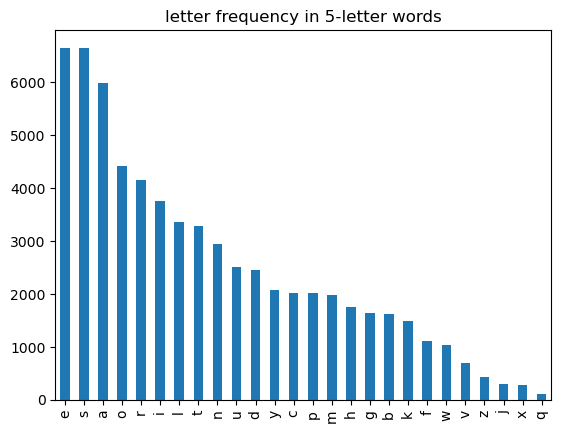

In [6]:
# letter prevalence as a whole
(five_letter_words
    .apply(lambda x: list(x))
    .explode()
    .value_counts()
    .plot(
        kind="bar",
        title="letter frequency in 5-letter words",
        ));

<Axes: title={'center': 'How often does a letter appear in a 5 letter word?'}>

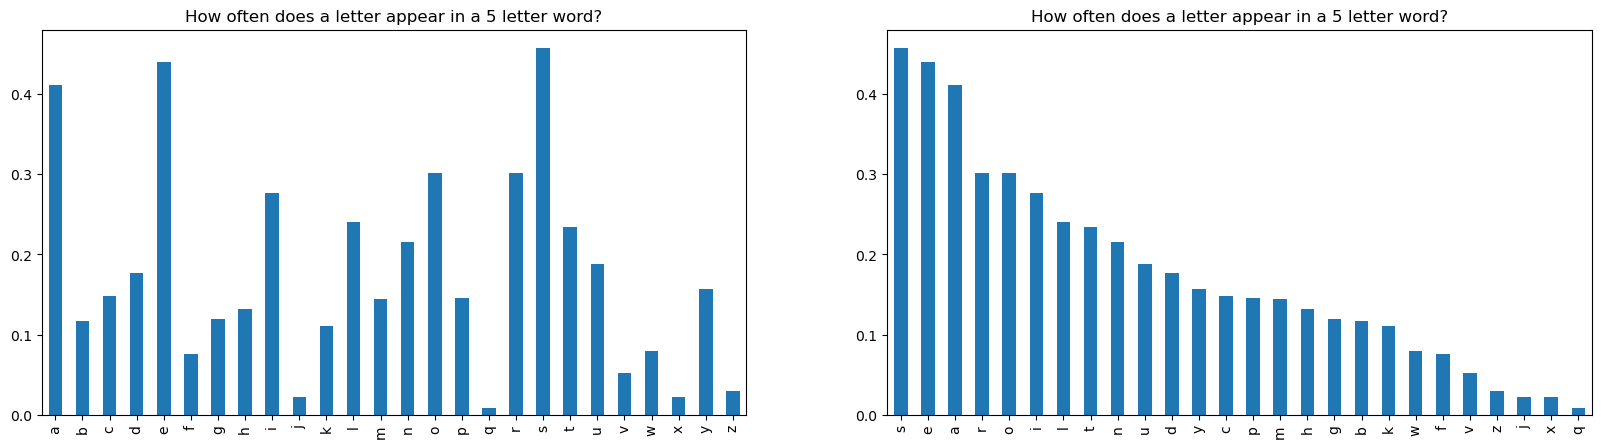

In [7]:
ALPHABET = "abcdefghijklmnopqrstuvwxyz"
# how often does a letter appear in a 5 letter word?
letter_frequency = pd.Series({letter: five_letter_words.str.contains(letter).mean() for letter in ALPHABET})

fig, ax = plt.subplots(1,2, figsize=(20,5))
letter_frequency.plot.bar(title="How often does a letter appear in a 5 letter word?", ax=ax[0])
letter_frequency.sort_values(ascending=False).plot.bar(title="How often does a letter appear in a 5 letter word?", ax=ax[1])

In [8]:
sample_words = np.random.choice(list(allowed_words.keys()), 200, replace=False)
sample_words = {word: allowed_words[word] for word in sample_words}

## Building a map of possible solutions given a guess outcome
### v1: no prior assumption about actual possible solutions

In [9]:
psm = wd.PossibleSolutionsMap(allowed_words, list(allowed_words))
%time psm.build_map()
print(psm)

%time psm.to_pickle(DATA_PATH / WORDS_PAIRS_FNAME.format(version="v1"))

  0%|          | 0/12953 [00:00<?, ?it/s]

CPU times: user 24min 39s, sys: 45.1 s, total: 25min 24s
Wall time: 25min 1s
PossibleSolutionsMap(n_solutions=12953,n_allowed=12953,entropy=13.66)
CPU times: user 12.1 ms, sys: 41.2 ms, total: 53.3 ms
Wall time: 62.9 ms


### v2: using prior knowledge about actual possible words

In [10]:
psm_v2 = wd.PossibleSolutionsMap({word: 1.0 for word in possible_words}, list(allowed_words))
%time psm_v2.build_map()
print(psm_v2)

%time psm_v2.to_pickle(DATA_PATH / WORDS_PAIRS_FNAME.format(version="v2"))

  0%|          | 0/2309 [00:00<?, ?it/s]

CPU times: user 4min 25s, sys: 9.94 s, total: 4min 35s
Wall time: 4min 30s
PossibleSolutionsMap(n_solutions=2309,n_allowed=12953,entropy=11.17)
CPU times: user 3.23 ms, sys: 7.96 ms, total: 11.2 ms
Wall time: 12.4 ms


# Reload

In [5]:
# reload
psm = wd.PossibleSolutionsMap.from_pickle(DATA_PATH / WORDS_PAIRS_FNAME.format(version="v1"))
psm_v2 = wd.PossibleSolutionsMap.from_pickle(DATA_PATH / WORDS_PAIRS_FNAME.format(version="v2"))

In [23]:
def simulate_game_so_far(solution: str, guesses: list[str]):
    game = wd.WordleGame(solution)
    for guess in guesses:
        game.record_player_guess(guess)
        wd.display_wordle_guess_outcome(game.guesses_so_far[-1])
    
    return game

## test performance with caching of entropies calculation for all candidates

In [13]:
# game start: all words are possible solutions (map = 13k x 13k)
%time candidate_entropies = wd.player.get_all_candidate_entropies(psm)
%time candidate_entropies = wd.player.get_all_candidate_entropies(psm)

# after one guess: 
%time candidate_entropies = wd.player.get_all_candidate_entropies(psm2)

CPU times: user 12.1 s, sys: 2.19 s, total: 14.3 s
Wall time: 15.2 s
CPU times: user 520 µs, sys: 26 µs, total: 546 µs
Wall time: 549 µs
CPU times: user 3.28 s, sys: 207 ms, total: 3.49 s
Wall time: 3.58 s


In [11]:
player = wd.player.GreedyPlayer(psm_v2)
game = wd.WordleGame("round")
%time wd.player.play_game(player, game=game)



CPU times: user 7.02 s, sys: 79.6 ms, total: 7.1 s
Wall time: 7.1 s


WordleGame(target_word='ROUND', max_guesses=6, number_of_guesses=3, is_over=True, solved=True)

# Visualizing outcome distributions
## best starter guesses

In [102]:
wd.player.get_all_candidate_entropies(psm_v2).head(5)

soare    5.885203
roate    5.884856
raise    5.878303
reast    5.867738
raile    5.865154
dtype: float64

In [123]:
wd.display.plot_distrib("soare", psm_v2)

Comments: no outcome is more than 8% likely to happen.
## worst starting guesses

In [105]:
wd.player.get_all_candidate_entropies(psm_v2).tail(5)

yukky    2.205343
xylyl    2.189638
immix    2.055325
jujus    2.039470
qajaq    1.890193
dtype: float64

In [124]:
wd.display.plot_distrib("yukky", psm_v2)

**Comments**: the distribution is very unbalanced with almost 60% chance to get zero letters matching and the two next outcomes being matched by over 10% of the possible solutions.

# Evaluation
* **goal**: maximize average score

In [110]:
def run_eval(config) -> tuple[wd.eval.EvalResults, go.Figure]:

    wd.player.get_all_candidate_entropies.cache_clear()
    eval_words_list = load_words_as_list(config["path_to_eval_words_list"])
    
    results = wd.eval.eval_player(
        eval_words_list, 
        config["player"], 
        pool_size=1)

    # save results
    results.to_json(config["path_to_json_output"])
    print(f"results saved in `{config['path_to_json_output']}`")

    fig = results.barplot(title=config["fig_title"])
    fig.write_image(config["fig_name"])

    return results, fig

## Evaluating v1 - no prior

In [47]:
config = {
    "player": wd.player.GreedyPlayer(starting_psm=psm),
    "path_to_eval_words_list": DATA_PATH / "raw/possible_words.txt",
    "path_to_json_output": DATA_PATH / "outputs/eval_results_v1.json",
    "fig_title": "v1 - no prior on potential solutions",
    "fig_name": IMG_PATH / "eval_v1.png",
}

res, fig = run_eval(config)

EvalResults(size=2,309, avg_score=2.99, dist=[   0   22  414 1443  425    5    0], success_rate=100.0%)
results saved in `../data/outputs/eval_results_v1.json`


## Evaluating v2 - prior knowledge about exact list of potential solutions

In [ ]:
config = {
    "player": wd.player.GreedyPlayer(starting_psm=psm_v2),
    "path_to_eval_words_list": DATA_PATH / "raw/possible_words.txt",
    "path_to_json_output": DATA_PATH / "outputs/eval_results_v2.json",
    "fig_title": "v2 - strong prior on potential solutions",
    "fig_name": IMG_PATH / "eval_v2.png",
}

results, fig = run_eval(config)



EvalResults(size=2,309, avg_score=3.47, dist=[   0    1   67 1111 1098   32    0], success_rate=100.0%)
CPU times: user 48min 30s, sys: 33.9 s, total: 49min 4s
Wall time: 3h 27min 39s


### words with highest and lowest scores

In [ ]:
scores = pd.Series(results.scores).sort_values(ascending=False)
scores.head()

ovate    5
chaos    5
arson    5
bravo    5
adore    5
dtype: int64

In [ ]:
wd.play_game(player, wd.WordleGame("chaos"))

WordleGame(target_word='CHAOS', max_guesses=6, number_of_guesses=2, is_over=True, solved=True)

In [125]:
# lowest scores
scores.tail()

cover    2
witty    2
fever    2
parer    2
waver    1
dtype: int64

In [120]:
wd.player.play_game(player, wd.WordleGame("waver"))

WordleGame(target_word='WAVER', max_guesses=6, number_of_guesses=6, is_over=True, solved=True)

## Bonus: Comparing object sizes depending on outcome encoding technique


In [121]:
import sys
import numpy as np
import pandas as pd

n = 4_000

objs = {
    "np.uint8": np.random.randint(256, size=(n,n), dtype=np.uint8),
    "np.int64": np.random.randint(256, size=(n,n), dtype=np.int64),
    "np.string": np.array([["11012" for _ in range(n)] for _ in range(n)]),
    "pd.string": pd.DataFrame(np.array([["11012" for _ in range(n)] for _ in range(n)]), columns=[f"c{i}" for i in range(n)], index=[f"c{i}" for i in range(n)]),
    "pd.uint8": pd.DataFrame(np.random.randint(256, size=(n,n), dtype=np.uint8), columns=[f"c{i}" for i in range(n)], index=[f"c{i}" for i in range(n)]),
    }

for key, obj in objs.items():
    print(f"{key:<10}: {sys.getsizeof(obj) /1e6:,.1f} Mb")

np.uint8  : 16.0 Mb
np.int64  : 128.0 Mb
np.string : 320.0 Mb
pd.string : 992.2 Mb
pd.uint8  : 16.2 Mb


**Conclusion**: moving from string to uint8 allowes to reduce objects size by ~40x